## Kode Sumber Agglomerative Clustering

In [1]:
import numpy as np
import math
import copy as copy

class Agglomerative(object):
	
	def __init__(self, n_clusters=3, linkage="average-group"):
		self.n_clusters = n_clusters
		self.linkage = linkage
		self.clusters = []
		#added for predict
		self.cluster_centers = []
		self.prediction_cluster_center_for_data = []
		self.prediction_cluster_center_label_for_data = []

	def getPointDistance(self, sourcePoint, targetPoint):
		sum = 0
		for component in self.components:
			sum += (targetPoint[component] - sourcePoint[component]) ** 2
		distance = math.sqrt(sum)
		return distance

	def getSingleDistance(self, sourceCluster, targetCluster):
		minDistance = np.inf
		for i in sourceCluster:
			sourcePoint = self.data.iloc[i]
			for j in targetCluster:
				targetPoint = self.data.iloc[j]
				distance = self.getPointDistance(sourcePoint, targetPoint)
				if (distance < minDistance):
					minDistance = distance
		return minDistance

	def getCompleteDistance(self, sourceCluster, targetCluster):
		maxDistance = -1 * np.inf
		for i in sourceCluster:
			sourcePoint = self.data.iloc[i]
			for j in targetCluster:
				targetPoint = self.data.iloc[j]
				distance = self.getPointDistance(sourcePoint, targetPoint)
				if (distance > maxDistance):
					maxDistance = distance
		return maxDistance

	def getAverageDistance(self, sourceCluster, targetCluster):
		averageDistance = 0
		for i in sourceCluster:
			sourcePoint = self.data.iloc[i]
			averageDistancePerOneObject = 0
			for j in targetCluster:
				targetPoint = self.data.iloc[j]
				distance = self.getPointDistance(sourcePoint, targetPoint)
				averageDistancePerOneObject += distance
			averageDistancePerOneObject /= len(targetCluster)
			averageDistance += averageDistancePerOneObject
		averageDistance /= len(sourceCluster)	
		return averageDistance

	def getClusterCenterPoint(self, cluster):
		center = {}
		for component in self.components:
			center[component] = 0
			for i in cluster:
				center[component] += self.data.iloc[i][component]
			center[component] /= len(cluster)
		return center
		
	def getAverageGroupDistance(self, sourceCluster, targetCluster):
		sourcePoint = self.getClusterCenterPoint(sourceCluster)
		targetPoint = self.getClusterCenterPoint(targetCluster)
		return self.getPointDistance(sourcePoint, targetPoint)

	def getClusterDistance(self, sourceIdx, targetIdx):
		sourceCluster = self.clusters[sourceIdx]
		targetCluster = self.clusters[targetIdx]
		if (self.linkage == "single"):
			return self.getSingleDistance(sourceCluster, targetCluster)
		elif (self.linkage == "complete"):
			return self.getCompleteDistance(sourceCluster, targetCluster)
		elif (self.linkage == "average"):
			return self.getAverageDistance(sourceCluster, targetCluster)
		elif (self.linkage == "average-group"):
			return self.getAverageGroupDistance(sourceCluster, targetCluster)
		else:
			raise Exception("404 Linkage not found")

	def getClusterIndexPair(self):
		source = None
		target = None
		minDistance = np.inf
		for i in range(len(self.clusters)):
			for j in range(len(self.clusters)):
				if (j>i):
					distance = self.getClusterDistance(i, j)
					if (distance<minDistance):
						source = i
						target = j
						minDistance = distance
		return source, target

	def updateClusters(self):
		source, target = self.getClusterIndexPair()
		targetCluster = self.clusters.pop(target)
		for data in targetCluster:
			self.clusters[source].append(data)

	def fit(self, X):
		self.data = X
		self.components = self.data.iloc[0].keys()
		# print(self.components)
		for i in range(len(X)):
			self.clusters.append([i])
		while(len(self.clusters) > self.n_clusters):
			self.updateClusters()
		#self.cluster_centers = []
		for cluster in self.clusters:
			self.cluster_centers.append(self.getClusterCenterPoint(cluster))

	def getNearestClusterIdx(self, point):
		min = np.inf
		retClusterIdx = None
		for i in range(len(self.cluster_centers)):
			distance = self.getPointDistance(point, self.cluster_centers[i])
			if (distance < min):
				min = distance
				retClusterIdx = i
		return retClusterIdx
	
	def predict(self, data):
		#classify array of data to respective cluster centers, return cluster label
		self.data = data
		datum_centers = []
		predicted_cluster_label_for_data = []
		data_clusters = []
		for index in range(len(data)):
			datum_centers.append(self.getClusterCenterPoint([index]))
		for datum_center in datum_centers:
			predicted_cluster_label_for_datum = self.getNearestClusterIdx(datum_center)
			predicted_cluster_label_for_data.append(predicted_cluster_label_for_datum)
		return predicted_cluster_label_for_data

	def print(self):
		for cluster in self.clusters:
			print (cluster)
			print(len(cluster))
		for midpoint in self.cluster_centers:
			for component in self.components:
				print(midpoint[component], end=",  ")
			print()

## Evaluasi dan Visualisasi

n_clusters = 2
Menggunakan metode Fowlkes-Mallows: 
Fowlkes Mallows Score: 0.7572110708864551
Menggunakan metode Silhouette:
Hasil rata-rata skor silhouette: 0.6829989771066655


n_clusters = 3
Menggunakan metode Fowlkes-Mallows: 
Fowlkes Mallows Score: 0.8208080729114153
Menggunakan metode Silhouette:
Hasil rata-rata skor silhouette: 0.5525919445499757


n_clusters = 4
Menggunakan metode Fowlkes-Mallows: 
Fowlkes Mallows Score: 0.7781783515966241
Menggunakan metode Silhouette:
Hasil rata-rata skor silhouette: 0.4678123347934199


n_clusters = 5
Menggunakan metode Fowlkes-Mallows: 
Fowlkes Mallows Score: 0.746570138601456
Menggunakan metode Silhouette:
Hasil rata-rata skor silhouette: 0.33990546755100737


n_clusters = 6
Menggunakan metode Fowlkes-Mallows: 
Fowlkes Mallows Score: 0.7029611568190188
Menggunakan metode Silhouette:
Hasil rata-rata skor silhouette: 0.31171555832592984




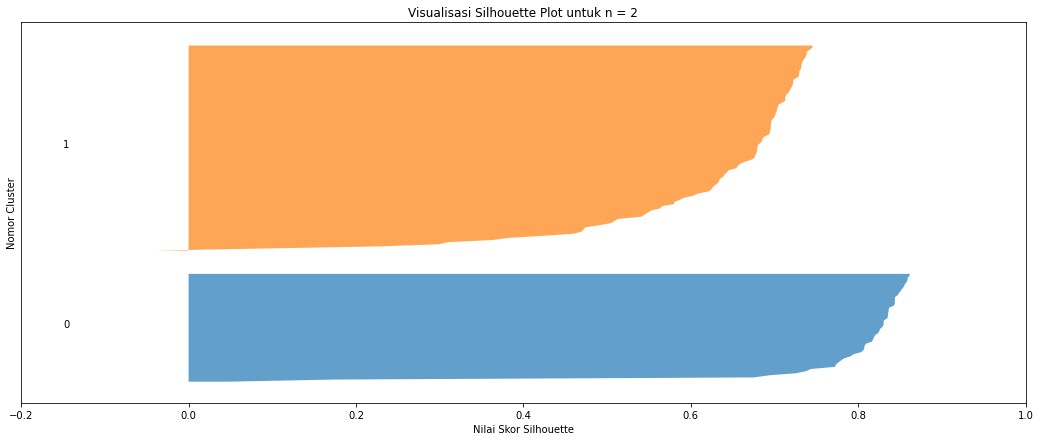

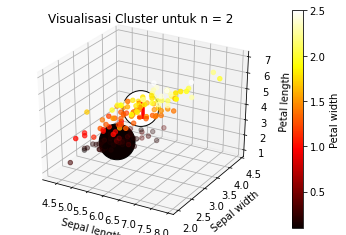

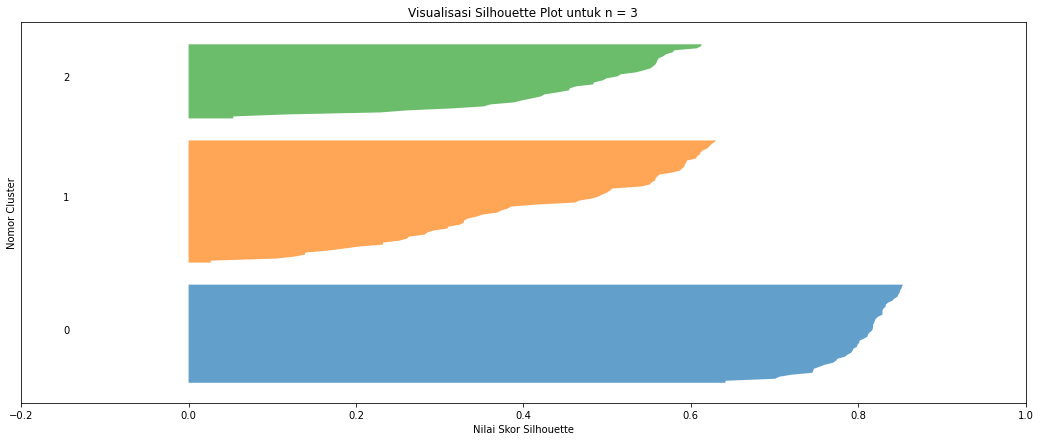

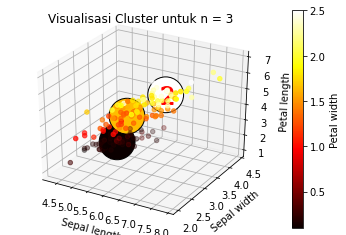

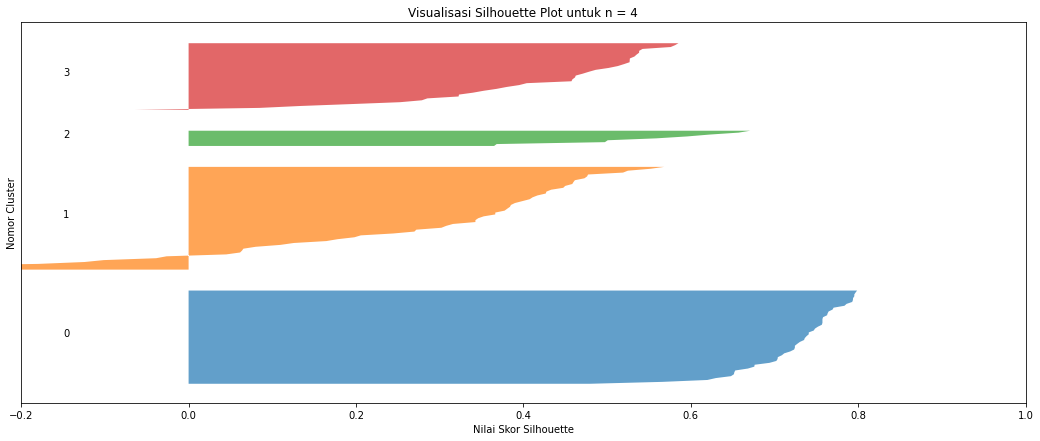

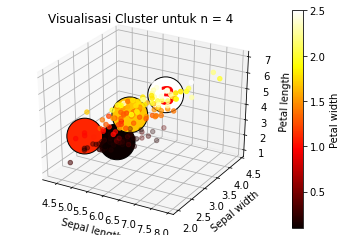

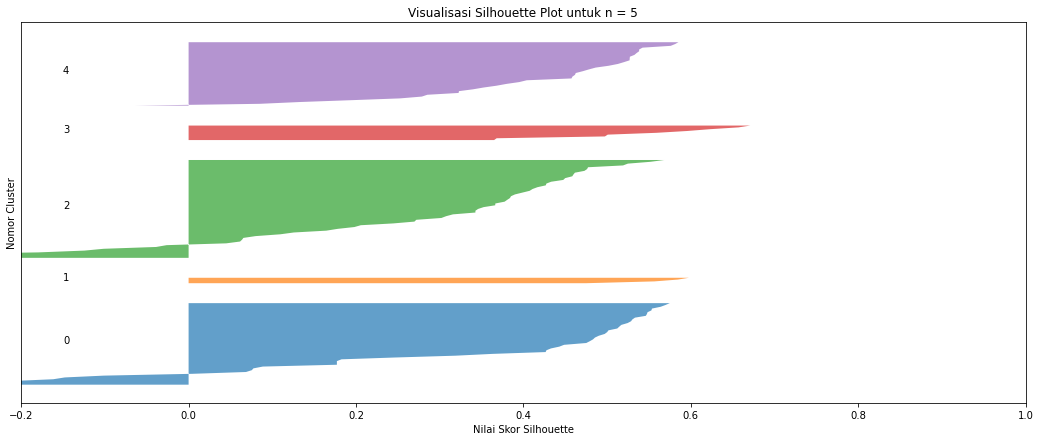

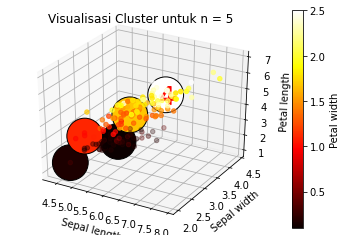

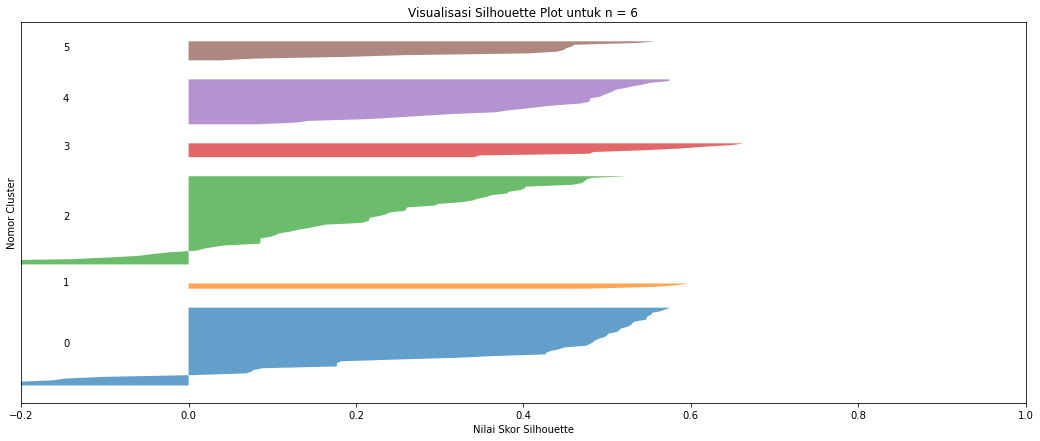

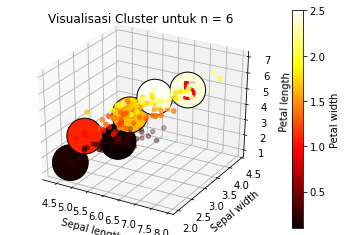

In [2]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score

data = pd.read_csv("iris.csv")
target = data.species
data_copy = copy.copy(data)

# Drop the class
inputs = data.drop('species', axis = 1)

# Test from n_clusters = 2 until n_clusters = 6
for n_clusters in range(2, 6+1):
    # Fowkes-Mallows and Silhouette evaluation:
    agglo = Agglomerative(n_clusters=n_clusters)
    agglo.fit(inputs)
    labels = np.array(agglo.predict(inputs))
    
    print("n_clusters =", n_clusters)

    print("Menggunakan metode Fowlkes-Mallows: ")
    fowlkes_mallows = fowlkes_mallows_score(labels, target)
    print("Fowlkes Mallows Score:", fowlkes_mallows)

    print("Menggunakan metode Silhouette:")
    silhouette_avg = silhouette_score(inputs, labels)
    print("Hasil rata-rata skor silhouette:", silhouette_avg)
    print()
    print()

    silhouette_values_per_point = silhouette_samples(inputs, labels)

    # Visualize Silhouette subplot
    # 1 row and 2 columns: Left -> silhouette plot and Right -> Cluster Visualization
    fig, silhouette_viz = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # Silhouette score ranges from -1 until 1
    silhouette_viz.set_xlim([-0.2, 1])
    silhouette_viz.set_ylim([0, len(inputs) + (n_clusters + 1) * 10])

    y_lower = 10
    
    for idx_cluster in range(n_clusters):
        cluster_silhouette_values = silhouette_values_per_point[labels == idx_cluster]
        # See the variance
        cluster_silhouette_values.sort()
        y_upper = y_lower + len(cluster_silhouette_values)
        silhouette_viz.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values, alpha=0.7)
        silhouette_viz.text(-0.15, y_lower + 0.5 * len(cluster_silhouette_values), str(idx_cluster))
        y_lower = y_upper + 10

    silhouette_viz.set_xlabel("Nilai Skor Silhouette")
    silhouette_viz.set_ylabel("Nomor Cluster")

    silhouette_viz.set_yticks([])  # Clear the yaxis labels / ticks
    silhouette_viz.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    silhouette_viz.set_title("Visualisasi Silhouette Plot untuk n = " + str(n_clusters))

    fig2 = plt.figure()
    cluster_viz = fig2.add_subplot(111, projection='3d')

    # Visualization for Clusters
    img = cluster_viz.scatter(data["sepal_length"], data["sepal_width"], data["petal_length"], c=data["petal_width"], cmap=plt.hot())

    cluster_viz.set_xlabel("Sepal length")
    cluster_viz.set_ylabel("Sepal width")
    cluster_viz.set_zlabel("Petal length")

    cluster_viz.set_title("Visualisasi Cluster untuk n = " + str(n_clusters))

    fig2.colorbar(img).ax.set_ylabel("Petal width")

    center = agglo.cluster_centers

    # For visualization purposes
    data_viz_dict = {}

    for key in center[0].keys():
        data_viz_dict[key] = []

    for i in range (len(center)):
        for key in center[i].keys():
            data_viz_dict[key].append(center[i][key])

    cluster_viz.scatter(data_viz_dict["sepal_length"], data_viz_dict["sepal_width"], data_viz_dict["petal_length"],
                        c=data_viz_dict["petal_width"], marker="o", edgecolor="k", s= 20*4**3, alpha=1)

    for i in range (len(center)):
        cluster_viz.scatter(center[i]["sepal_length"], center[i]["sepal_width"], center[i]["petal_length"],
                            c="red", marker='$%d$' % i, s=20*4**2, alpha=1)

plt.show()

Evaluasi yang kami lakukan menggunakan metrik Fowlkes-Mallows score dan Silhouette Coefficient

Fowlkes-Mallows score adalah sebuah metode evaluasi dalam cluster analysis yang digunakan untuk menentukan kesamaan antara dua clustering. Fowlkes-Mallows score merupakan metode evaluasi eksternal, yaitu metode evaluasi di mana hasil clustering dievaluasi berdasarkan data yang tidak digunakan untuk clustering. Ukuran kesamaan ini bisa antara dua clustering hierarkis ataupun satu clustering hierarkis dan satu klasifikasi benchmark. Nilai yang lebih tinggi untuk Fowlkes-Mallows score menunjukkan kesamaan yang lebih besar antar dua clustering hierarkis, atau antar satu clustering hierarkis dan satu klasifikasi benchmark, tergantung ukuran kesamaan yang digunakan.

Silhouette adalah metode interpretasi dan validasi konsistensi dalam cluster. Metode ini memberikan representasi grafis tentang seberapa baik setiap datum telah diklasifikasikan. 

Silhouette score adalah sebuah ukuran dari semirip apa sebuah datum dengan clusternya sendiri, dibandingkan dengan cluster lain. Silhouette score berkisar dari -1 sampai +1. i mana nilai yang tinggi menunjukkan bahwa objek tersebut cocok dengan clusternya sendiri dan tidak cocok dengan cluster tetangga. Jika sebagian besar objek memiliki nilai tinggi, maka konfigurasi clustering sesuai. Jika banyak titik memiliki nilai rendah atau negatif, maka konfigurasi clustering mungkin memiliki cluster yang terlalu banyak atau terlalu sedikit.

Metode python yang kami gunakan untuk mengukur Fowlkes-Mallows Score adalah fowlkes_mallows_score dari library sklearn.metrics.cluster. Metode fowlkes_mallows_score ini mengambil parameter label data yang dihasilkan dari Kmeans, dan target berupa label data yang didapat dari data awal.

Metode python yang kami gunakan untuk mengukur Silhouette score adalah silhouette_score dari sklearn.metrics. Silhouette_score ini mengambil parameter label data yang dihasilkan dari Kmeans, dan target berupa label data yang didapat dari data awal.

Kami melakukan clustering dengan jumlah cluster 2 sampai 6. Hasilnya adalah:
* Jumlah cluster 2
    * Fowlkes Mallows Score: 0.7572110708864551
    * Hasil rata-rata skor Silhouette: 0.6829989771066655
* Jumlah cluster 3
    * Fowlkes Mallows Score: 0.8208080729114153
    * Hasil rata-rata skor Silhouette: 0.5525919445499757
* Jumlah cluster 4
    * Fowlkes Mallows Score: 0.7781783515966241
    * Hasil rata-rata skor Silhouette: 0.4678123347934199
* Jumlah cluster 5
    * Fowlkes Mallows Score: 0.746570138601456
    * Hasil rata-rata skor Silhouette: 0.37124884800823255
* Jumlah cluster 6
    * Fowlkes Mallows Score: 0.7029611568190188
    * Hasil rata-rata skor Silhouette: 0.31171555832592984

## Analisis

Didapatkan bahwa clustering dengan jumlah cluster 3 memiliki Fowlkes Mallows Score tertinggi. Jadi, menurut Fowlkes-Mallows Score, hasil clustering dengan jumlah cluster 3 memiliki kesamaan yang lebih paling besar dengan clustering pada training data, sehingga menurut Fowlkes-Mallows, hasil clustering dengan jumlah cluster 3 paling baik.

Didapatkan juga bahwa semakin banyak clusternya, overall score untuk Silhouette semakin rendah. Hal ini disebabkan karena semakin banyak clusternya, jarak antar cluster menjadi semakin sedikit, sehingga satu datum yang diklasifikasikan dalam satu cluster dapat menjadi semakin cocok dengan cluster lainnya juga, sehingga menurut Silhouette, semakin sedikit jumlah clusternya, hasilnya semakin baik, dan hasil clustering dengan jumlah cluster 2 paling baik.